# Fraud Detection with Kaggle Credit Card Dataset (Colab-Ready)

**Dataset:** Kaggle Credit Card Fraud Detection (`creditcard.csv`) — fields: `Time`, `V1…V28`, `Amount`, `Class` (1 = fraud)

**What this notebook does:**
- Loads the ZIP (`creditcard.csv.zip`) and prepares the dataset (`Class` → `is_fraud`, `Amount` → `amount`).
- EDA and class imbalance check.
- Baseline Logistic Regression and XGBoost.
- **Business cost–aware threshold tuning** (False Negative vs False Positive).
- **Mini streaming simulation** over events.
- Saves artifacts for a dashboard: model, metrics, sample CSV.

> Tip: In Colab, upload your `creditcard.csv.zip` via the upload cell below or mount Drive and point to the path.

In [10]:

#@title Environment setup
# !pip install xgboost==2.0.3  # uncomment if your runtime lacks xgboost

import os, io, time, json, zipfile, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import joblib
import xgboost as xgb

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Environment ready.")


Environment ready.


## 1) Load Dataset from ZIP
Upload `creditcard.csv.zip` (the Kaggle dataset). This cell will unzip and load it into a DataFrame.

In [11]:

#@title Upload or point to an existing path
from pathlib import Path
df = None

# 1) Try Colab upload
try:
    from google.colab import files  # type: ignore
    print("Colab detected. Use the file chooser to upload creditcard.csv.zip")
    uploaded = files.upload()
    if uploaded:
        # take first file
        fname = list(uploaded.keys())[0]
        import io, zipfile, pandas as pd
        with zipfile.ZipFile(io.BytesIO(uploaded[fname])) as zf:
            zf.extractall("/content")
        csv_path = "/content/creditcard.csv"
        df = pd.read_csv(csv_path)
        print("Loaded from upload:", csv_path, df.shape)
except Exception as e:
    print("Colab upload not available or skipped.")

# 2) Fallback: use a known local path (useful if running outside Colab and file exists)
if df is None:
    fallback_zip_paths = [
        "/content/creditcard.csv.zip",
        "/mnt/data/creditcard.csv.zip",
        "creditcard.csv.zip"
    ]
    found = None
    for p in fallback_zip_paths:
        if Path(p).exists():
            found = p
            break
    if found is not None:
        print("Found ZIP at:", found)
        import zipfile, pandas as pd
        with zipfile.ZipFile(found, 'r') as zf:
            zf.extractall("/tmp/cc_data")
        csv_path = "/tmp/cc_data/creditcard.csv"
        df = pd.read_csv(csv_path)
        print("Loaded from fallback:", csv_path, df.shape)

if df is None:
    raise FileNotFoundError("Could not load dataset. Upload creditcard.csv.zip or place it at one of the fallback paths.")


Colab detected. Use the file chooser to upload creditcard.csv.zip


Saving creditcard.csv.zip to creditcard.csv.zip
Loaded from upload: /content/creditcard.csv (284807, 31)


## 2) Prepare Columns

In [12]:

# Rename columns to project schema
df.rename(columns={'Class': 'is_fraud', 'Amount': 'amount'}, inplace=True)

# Optional: drop 'Time' as it's not directly informative for our static model
if 'Time' in df.columns:
    df.drop(columns=['Time'], inplace=True)

# Ensure target is binary int
df['is_fraud'] = df['is_fraud'].astype(int)

print(df.shape)
df.head()


(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,amount,is_fraud
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3) Quick EDA & Imbalance Check

Rows, Cols: (284807, 30)
Fraud rate: 0.001727


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,amount,is_fraud
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<Figure size 640x480 with 0 Axes>

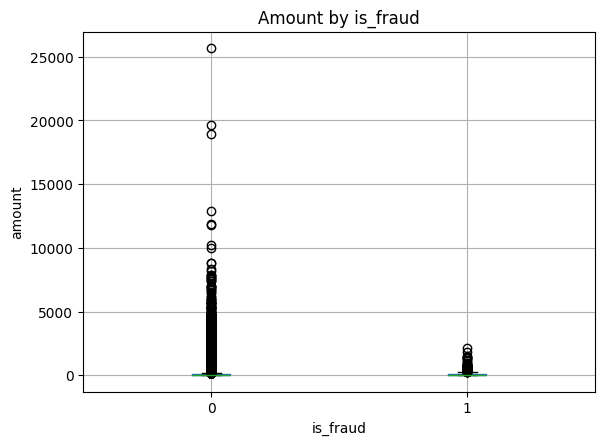

In [13]:

print("Rows, Cols:", df.shape)
fraud_rate = df['is_fraud'].mean()
print("Fraud rate:", round(fraud_rate, 6))

display(df.describe(include=[np.number]))

# Distribution of amount by class (simple boxplot)
plt.figure()
df.boxplot(column='amount', by='is_fraud')
plt.suptitle('')
plt.title('Amount by is_fraud')
plt.xlabel('is_fraud')
plt.ylabel('amount')
plt.show()


## 4) Feature Engineering & Split

In [14]:

target = 'is_fraud'
features = [c for c in df.columns if c != target]

num_cols = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df[features].select_dtypes(include=['object','category']).columns.tolist()

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))


Numeric: 29 | Categorical: 0


## 5) Baseline Model — Logistic Regression

In [15]:

logreg = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

logreg.fit(X_train, y_train)
proba_lr = logreg.predict_proba(X_test)[:,1]
auc_lr = roc_auc_score(y_test, proba_lr)
print("Logistic AUC:", round(auc_lr, 5))


Logistic AUC: 0.97146


## 6) Gradient Boosting — XGBoost

In [16]:

pos = (y_train==1).sum()
neg = (y_train==0).sum()
scale_pos_weight = neg / max(1, pos)

xgb_clf = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.0,
        reg_lambda=1.0,
        tree_method='hist',
        eval_metric='auc',
        random_state=RANDOM_SEED,
        scale_pos_weight=scale_pos_weight
    ))
])

xgb_clf.fit(X_train, y_train)
proba_xgb = xgb_clf.predict_proba(X_test)[:,1]
auc_xgb = roc_auc_score(y_test, proba_xgb)
print("XGBoost AUC:", round(auc_xgb, 5))


XGBoost AUC: 0.97509


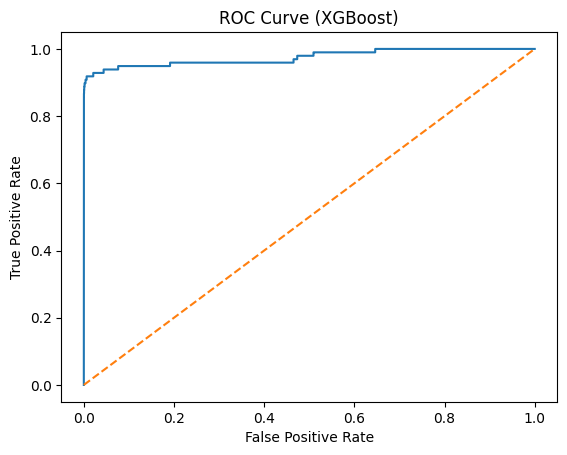

AUC: 0.97509


In [17]:

fpr, tpr, thresholds = roc_curve(y_test, proba_xgb)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.show()
print("AUC:", round(auc_xgb, 5))


## 7) Threshold Tuning with Business Costs

Best threshold: 0.01435
Min cost: 2356.0 Precision: 0.6259 Recall: 0.8878


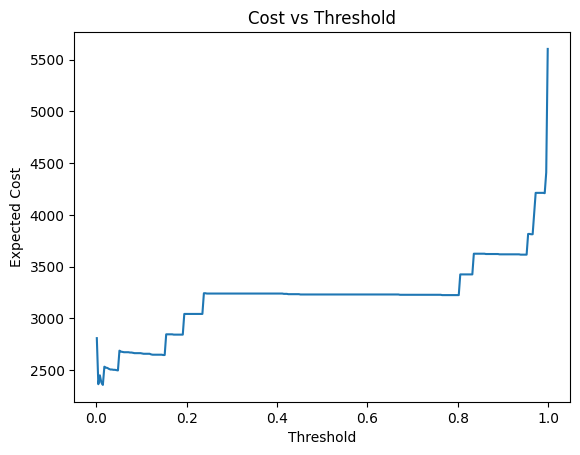

,thr,tn,fp,fn,tp,precision,recall,f1,cost
0,0.001000,56528,336,9,89,0.209412,0.908163,0.340344,2808.0
1,0.004338,56743,121,10,88,0.421053,0.897959,0.573290,2363.0
2,0.007676,56781,83,11,87,0.511765,0.887755,0.649254,2449.0
3,0.011013,56804,60,11,87,0.591837,0.887755,0.710204,2380.0
4,0.014351,56812,52,11,87,0.625899,0.887755,0.734177,2356.0


In [18]:

#@title Set Business Costs
#@markdown Set the **cost of a False Negative** (missed fraud) and **False Positive** (blocked legit txn)
COST_FN = 200.0 #@param {type:'number'}
COST_FP = 3.0   #@param {type:'number'}

from dataclasses import dataclass

def evaluate_threshold(y_true, y_score, thr, cost_fn, cost_fp):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cost = fp*cost_fp + fn*cost_fn
    return {'thr':thr, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp,
            'precision':precision, 'recall':recall, 'f1':f1, 'cost':cost}

grid = np.linspace(0.001, 0.999, 300)
stats = [evaluate_threshold(y_test, proba_xgb, t, COST_FN, COST_FP) for t in grid]
df_thr = pd.DataFrame(stats)
best = df_thr.sort_values('cost').iloc[0]
best_thr = float(best['thr'])
print("Best threshold:", round(best_thr,5))
print("Min cost:", round(best['cost'],2),
      "Precision:", round(best['precision'],4), "Recall:", round(best['recall'],4))

plt.figure()
plt.plot(df_thr['thr'], df_thr['cost'])
plt.xlabel('Threshold')
plt.ylabel('Expected Cost')
plt.title('Cost vs Threshold')
plt.show()

df_thr.head()


## 8) Save Artifacts

In [19]:

import json, os, numpy as np, pandas as pd, joblib

os.makedirs('artifacts', exist_ok=True)
joblib.dump(xgb_clf, 'artifacts/xgb_pipeline.joblib')

metrics = {
    'auc_xgb': float(auc_xgb),
    'best_threshold': float(best_thr),
    'best_cost': float(best['cost']),
    'precision_at_best': float(best['precision']),
    'recall_at_best': float(best['recall']),
    'fraud_rate': float((y==1).mean())
}
with open('artifacts/metrics.json','w') as f:
    json.dump(metrics, f, indent=2)

# balanced sample for dashboard
df_sample = df.sample(20000, random_state=42)
df_sample.to_csv('artifacts/transactions_sample.csv', index=False)

print("Saved: artifacts/xgb_pipeline.joblib, artifacts/metrics.json, artifacts/transactions_sample.csv")


Saved: artifacts/xgb_pipeline.joblib, artifacts/metrics.json, artifacts/transactions_sample.csv


## 9) Streaming Simulation (Toy Real-Time Loop)

Processed: 3000 | Alerts: 3 | Missed frauds: 0
Avg latency (ms): 23733.57


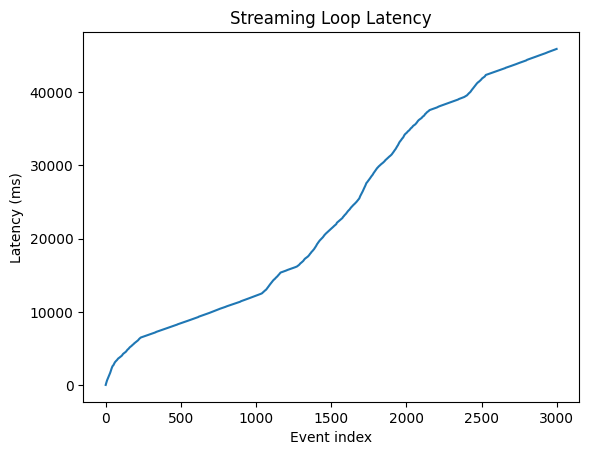

In [20]:

events = df.sample(3000, random_state=42).reset_index(drop=True)

alerts = 0
missed = 0
latencies = []

t0 = time.time()
for i in range(len(events)):
    ev = events.iloc[i]
    X_one = pd.DataFrame([ev.drop('is_fraud')])
    score = float(xgb_clf.predict_proba(X_one)[0][1])
    alert = int(score >= best_thr)
    alerts += alert
    missed += int((alert == 0) and (int(ev['is_fraud']) == 1))
    latencies.append(time.time() - t0)
    time.sleep(0.001)  # simulate minimal processing delay

print(f"Processed: {len(events)} | Alerts: {alerts} | Missed frauds: {missed}")
print(f"Avg latency (ms): {np.mean(latencies)*1000:.2f}")

plt.figure()
plt.plot(np.arange(len(latencies)), np.array(latencies)*1000)
plt.xlabel('Event index')
plt.ylabel('Latency (ms)')
plt.title('Streaming Loop Latency')
plt.show()


## 10) Inference Helper (Single Transaction)

In [21]:

# Construct a plausible event using median amounts and zeroed PCA components
example = {c: 0.0 for c in X.columns}
if 'amount' in example:
    example['amount'] = float(df['amount'].median())
X_one = pd.DataFrame([example])
prob = float(xgb_clf.predict_proba(X_one)[0][1])
print("Fraud probability:", round(prob,6), "| Alert:", int(prob >= best_thr))


Fraud probability: 4e-06 | Alert: 0


## 11) README Checklist
- Problem statement & business context (fraud losses, ops impact)
- Dataset summary (size, features, imbalance)
- Models tried (LogReg, XGBoost) and metrics (AUC)
- **Cost-aware threshold tuning** (show chosen costs, threshold, precision/recall)
- Streaming simulation (method & caveats)
- Artifacts: model, metrics.json, sample CSV
- Next steps: Streamlit risk dashboard (alerts feed, KPI tiles, cost trend), drift monitoring


In [22]:
# Colab: install Streamlit + ngrok + core libs
!pip -q install streamlit pyngrok xgboost scikit-learn pandas matplotlib


In [23]:
NGROK_AUTH_TOKEN = "2zFKMMZWHPukNBKiGu5epxw6joh_3QarGiyDF5xv3V9DHm2dd"


In [27]:
%%writefile app.py
import os, json, time, io, zipfile, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import roc_curve, precision_recall_curve


st.set_page_config(page_title="Fraud Risk Dashboard", layout="wide")

# ---------------------------
# Helpers
# ---------------------------
def load_artifacts(uploaded_metrics, uploaded_model, uploaded_sample):
    metrics = None
    model = None
    df_sample = None

    if uploaded_metrics is not None:
        metrics = json.load(uploaded_metrics)

    if uploaded_model is not None:
        model_bytes = uploaded_model.read()
        tmp_path = os.path.join(tempfile.gettempdir(), "xgb_pipeline.joblib")
        with open(tmp_path, "wb") as f:
            f.write(model_bytes)
        model = joblib.load(tmp_path)

    if uploaded_sample is not None:
        df_sample = pd.read_csv(uploaded_sample)

    return metrics, model, df_sample

def ensure_schema(df):
    # Kaggle credit card dataset columns: Time, V1..V28, Amount, Class
    cols = df.columns.str.lower().tolist()
    col_map = {}
    if "class" in cols:
        col_map[df.columns[cols.index("class")]] = "is_fraud"
    if "amount" in cols:
        col_map[df.columns[cols.index("amount")]] = "amount"
    df = df.rename(columns=col_map)
    # Drop Time if present
    if "Time" in df.columns: df = df.drop(columns=["Time"])
    if "time" in df.columns: df = df.drop(columns=["time"])
    if "is_fraud" in df.columns:
        df["is_fraud"] = df["is_fraud"].astype(int)
    return df

def make_preprocessor(X):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    # OneHotEncoder API differences across sklearn versions
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ],
        remainder="drop"
    )
    return preprocessor

def quick_train_model(df):
    # Train a lightweight LogisticRegression if no model uploaded
    assert "is_fraud" in df.columns, "Dataset must contain 'is_fraud' label."
    y = df["is_fraud"].astype(int)
    X = df.drop(columns=["is_fraud"])
    pre = make_preprocessor(X)
    model = Pipeline(steps=[
        ("prep", pre),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model.fit(X_train, y_train)
    scores = model.predict_proba(X_test)[:, 1]
    auc = float(roc_auc_score(y_test, scores))
    # sensible default threshold via Youden or ~imbalanced-friendly small cut
    fpr, tpr, thr = roc_curve(y_test, scores)
    idx = np.argmax(tpr - fpr)
    default_thr = float(thr[idx])
    return model, (X_test, y_test, scores, auc, default_thr)

def metrics_at_threshold(y_true, scores, thr, cost_fn, cost_fp):
    y_pred = (scores >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cost = fp * cost_fp + fn * cost_fn
    return dict(
        tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp),
        precision=float(precision), recall=float(recall), f1=float(f1), cost=float(cost)
    )

def plot_cost_curve(y_true, scores, cost_fn, cost_fp):
    grid = np.linspace(0.001, 0.999, 300)
    costs = []
    for t in grid:
        m = metrics_at_threshold(y_true, scores, t, cost_fn, cost_fp)
        costs.append(m["cost"])
    fig, ax = plt.subplots()
    ax.plot(grid, costs)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Expected Cost")
    ax.set_title("Cost vs Threshold")
    st.pyplot(fig)
# === Visual helper functions ===
def plot_confusion_heatmap(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{int(v)}", ha="center", va="center", color="black")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Act 0", "Act 1"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    st.pyplot(fig)

def plot_roc_curve(y_true, scores):
    fpr, tpr, _ = roc_curve(y_true, scores)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="ROC")
    ax.plot([0, 1], [0, 1], "--", color="gray")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    st.pyplot(fig)

def plot_pr_curve(y_true, scores):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, label="PR")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall Curve")
    st.pyplot(fig)


def simulate_events(df_events, model, thr, n=200):
    # df_events must include 'is_fraud'
    events = df_events.sample(min(n, len(df_events)), random_state=42).copy()
    X = events.drop(columns=["is_fraud"])
    scores = model.predict_proba(X)[:, 1]
    alerts = (scores >= thr).astype(int)
    events["score"] = scores
    events["alert"] = alerts
    missed = int(((alerts == 0) & (events["is_fraud"] == 1)).sum())
    return events, int(alerts.sum()), missed

# ---------------------------
# UI
# ---------------------------
st.sidebar.header("Inputs / Artifacts")
uploaded_metrics = st.sidebar.file_uploader("metrics.json (optional)", type=["json"])
uploaded_model = st.sidebar.file_uploader("xgb_pipeline.joblib (optional)", type=["joblib"])
uploaded_sample = st.sidebar.file_uploader("transactions_sample.csv (optional)", type=["csv"])

st.sidebar.markdown("---")
st.sidebar.subheader("Or upload raw dataset (zip)")
uploaded_zip = st.sidebar.file_uploader("creditcard.csv.zip (optional)", type=["zip"])

st.sidebar.markdown("---")
cost_fn = st.sidebar.number_input("Cost of False Negative (missed fraud)", min_value=0.0, value=200.0, step=10.0)
cost_fp = st.sidebar.number_input("Cost of False Positive (blocked legit)", min_value=0.0, value=3.0, step=1.0)

st.title("🛡️ Fraud Risk Monitoring Dashboard")

metrics, model, df_sample = load_artifacts(uploaded_metrics, uploaded_model, uploaded_sample)

# If raw zip is provided and no sample/model given, load and optionally train
if df_sample is None and uploaded_zip is not None:
    try:
        with zipfile.ZipFile(uploaded_zip, 'r') as zf:
            zf.extractall(tempfile.gettempdir())
        csv_path = os.path.join(tempfile.gettempdir(), "creditcard.csv")
        raw = pd.read_csv(csv_path)
        raw = ensure_schema(raw)
        # keep a manageable subset for speed in app
        if len(raw) > 150_000:
            raw = raw.sample(150_000, random_state=42)
        # if no model uploaded, train a quick baseline
        if model is None:
            with st.spinner("Training a lightweight baseline model (LogReg)…"):
                model, pack = quick_train_model(raw)
                X_test, y_test, scores_test, auc, default_thr = pack
                # Make a sample set for simulation
                df_sample = pd.concat([X_test.reset_index(drop=True),
                                       pd.Series(y_test.values, name="is_fraud")], axis=1)
                metrics = {
                    "auc_xgb": auc,
                    "best_threshold": default_thr,
                    "precision_at_best": None,
                    "recall_at_best": None
                }
        else:
            # Model exists but no sample → use a labelled sample from raw
            X_train, X_test, y_train, y_test = train_test_split(
                raw.drop(columns=["is_fraud"]), raw["is_fraud"].astype(int),
                test_size=0.2, random_state=42, stratify=raw["is_fraud"]
            )
            df_sample = pd.concat([X_test.reset_index(drop=True),
                                   pd.Series(y_test.values, name="is_fraud")], axis=1)
    except Exception as e:
        st.error(f"Failed to load zip: {e}")

# If still no sample, create a tiny synthetic one to avoid app crashing (demo only)
if df_sample is None and model is not None:
    st.warning("No transactions_sample.csv provided. Using a small random demo sample (won't be representative).")
    # Try to infer expected columns from model pipeline
    demo = pd.DataFrame([{}])
    try:
        # safest: just create a 100-row dummy numeric frame with 'amount' and 'is_fraud'
        demo = pd.DataFrame({
            "amount": np.random.gamma(2.0, 50.0, 100),
            "is_fraud": np.random.binomial(1, 0.002, 100)
        })
    except:
        pass
    df_sample = demo

# Guardrails
if model is None and df_sample is None:
    st.info("➡️ Upload either (a) artifacts (model + sample), or (b) the Kaggle ZIP so the app can train a quick model.")
    st.stop()

# If we have labels, compute baseline AUC & default threshold
scores_for_eval = None
auc_val = None
default_thr = 0.5

if "is_fraud" in df_sample.columns:
    X_eval = df_sample.drop(columns=["is_fraud"])
    y_eval = df_sample["is_fraud"].astype(int).values
    try:
        scores_for_eval = model.predict_proba(X_eval)[:, 1]
        auc_val = float(roc_auc_score(y_eval, scores_for_eval))
        # Default threshold: use uploaded metrics if present, else Youden
        if metrics and "best_threshold" in metrics and metrics["best_threshold"] is not None:
            default_thr = float(metrics["best_threshold"])
        else:
            fpr, tpr, thr = roc_curve(y_eval, scores_for_eval)
            default_thr = float(thr[np.argmax(tpr - fpr)])
    except Exception as e:
        st.error(f"Scoring error: {e}")

# ---------------------------
# Layout
# ---------------------------
col1, col2, col3, col4 = st.columns(4)
with col1:
    st.metric("AUC", f"{(metrics.get('auc_xgb') if metrics else auc_val):.4f}" if (metrics or auc_val) else "—")
with col2:
    st.metric("Fraud Rate (sample)", f"{(df_sample['is_fraud'].mean()*100):.3f}%" if "is_fraud" in df_sample.columns else "—")
with col3:
    st.metric("Sample Size", f"{len(df_sample):,}")
with col4:
    st.metric("Model", "Uploaded" if metrics else ("Baseline LogReg" if auc_val else "Unknown"))

use_auto = st.checkbox("Use cost-optimal threshold (0.0145)", value=True)
thr = 0.0145 if use_auto else st.slider("Decision Threshold", 0.001, 0.99, value=0.0145, step=0.001)

# KPIs at threshold (if labels exist)
if scores_for_eval is not None:
    k = metrics_at_threshold(y_eval, scores_for_eval, thr, cost_fn, cost_fp)
    kpi1, kpi2, kpi3, kpi4 = st.columns(4)
    kpi1.metric("Precision", f"{k['precision']:.3f}")
    kpi2.metric("Recall", f"{k['recall']:.3f}")
    kpi3.metric("F1", f"{k['f1']:.3f}")
    kpi4.metric("Cost", f"{k['cost']:.0f}")

    # Confusion matrix
    st.markdown("#### Confusion Matrix & Curves")
    cm = np.array([[k['tn'], k['fp']], [k['fn'], k['tp']]])
    col_a, col_b, col_c = st.columns(3)
    with col_a:
      plot_confusion_heatmap(cm)
    with col_b:
      plot_roc_curve(y_eval, scores_for_eval)
    with col_c:
      plot_pr_curve(y_eval, scores_for_eval)


# Simulation
st.markdown("---")
st.markdown("### 🔴 Simulate Alerts")
n_events = st.number_input("Number of events to simulate", min_value=50, max_value=5000, value=500, step=50)
if st.button("Run Simulation"):
    if "is_fraud" not in df_sample.columns:
        st.error("Simulation requires 'is_fraud' label in the sample.")
    else:
        events, alerts, missed = simulate_events(df_sample, model, thr, int(n_events))
        st.success(f"Processed: {len(events):,} | Alerts: {alerts:,} | Missed frauds: {missed:,}")
        st.dataframe(events.head(20)[["amount"] + [c for c in events.columns if c.startswith("V")][:6] + ["score", "alert", "is_fraud"]])
        st.caption("Showing first 20 events; columns truncated for brevity.")

st.markdown("---")
st.caption("Tip: Upload your trained artifacts to see your real model’s KPIs. If none are provided, the app can train a quick baseline from the Kaggle ZIP.")


Overwriting app.py


In [28]:
import os, time, threading, textwrap
from pyngrok import ngrok

# Optional auth (recommended)
if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill stray tunnels
for t in ngrok.get_tunnels():
    ngrok.disconnect(t.public_url)

public_url = ngrok.connect(8501, "http")
print("Public URL:", public_url)

# Start streamlit (background)
def run_streamlit():
    os.system("streamlit run app.py --server.port 8501 --server.address 0.0.0.0")

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# Give it a moment to boot
time.sleep(3)
print("If the app hasn't loaded yet, wait a few seconds and refresh the public URL above.")


Public URL: NgrokTunnel: "https://3231d50b3224.ngrok-free.app" -> "http://localhost:8501"
If the app hasn't loaded yet, wait a few seconds and refresh the public URL above.
